In [73]:
import geopandas as gpd
import gzip
from io import BytesIO
import requests
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [74]:
project_code = "-NdeQ6m1-rSdBtJCh70K" # Nigeria
#project_code = "-NeiT6ffy2UydFQ9iUJu" # Bangladesh

In [75]:
url = f"https://apps.mapswipe.org/api/agg_results/agg_results_{project_code}_geom.geojson.gz"
response = requests.get(url)
gzipped_file = BytesIO(response.content)

# Unzip the gz file
with gzip.GzipFile(fileobj=gzipped_file) as f:
    gdf = gpd.read_file(f)

In [76]:
url = f"https://apps.mapswipe.org/api/results/results_{project_code}.csv.gz"

response = requests.get(url)
gzipped_file = BytesIO(response.content)

# Unzip the gz file
with gzip.GzipFile(fileobj=gzipped_file) as f:
    results = pd.read_csv(f)

In [77]:
def calc_agreement(row: pd.Series) -> float:
    """
    for each task the "agreement" is computed (i.e. the extent to which
    raters agree for the i-th subject). This measure is a component of
    Fleiss' kappa: https://en.wikipedia.org/wiki/Fleiss%27_kappa
    """

    # Calculate total count as the sum of all categories
    n = row["total_count"]

    row = row.drop(labels=["total_count"])
    # extent to which raters agree for the ith subject
    # set agreement to None if only one user contributed
    if n == 1 or n == 0:
        agreement = None
    else:
        agreement = (sum([i**2 for i in row]) - n) / (n * (n - 1))

    return agreement

In [78]:
gdf = gdf[['idx', 'task_id', '0_count', '1_count', '2_count', '3_count', '0_share', '1_share', '2_share', '3_share', 
       'total_count', 'agreement', "geometry"]]

In [79]:
gdf["corrected_agreement"] = gdf[["total_count", '0_count', '1_count', '2_count', '3_count']].apply(calc_agreement, axis = 1)

In [80]:
gdf["modal_answer"] = gdf[['0_count', '1_count', '2_count', '3_count']].idxmax(axis=1)

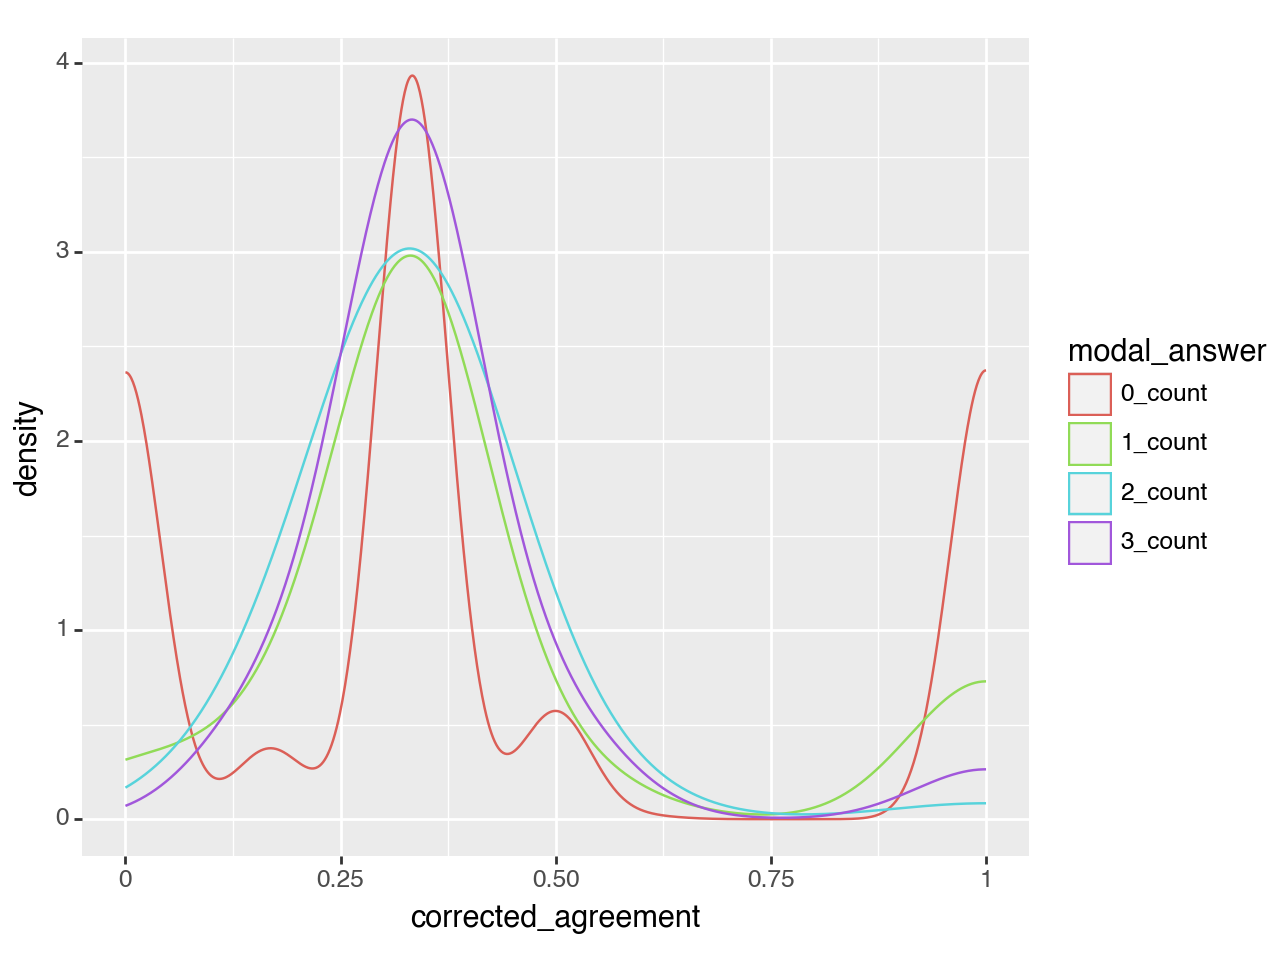

<Figure Size: (640 x 480)>

In [81]:
(ggplot(gdf, aes(x = "corrected_agreement", color = "modal_answer")) + geom_density())

In [82]:
result = gdf.groupby('modal_answer')['corrected_agreement'].agg(n='count', percentage=lambda x: (x == 1).mean() * 100).reset_index()
result

,modal_answer,n,percentage
0,0_count,4506,24.589436
1,1_count,437,16.247140
2,2_count,124,2.419355
3,3_count,666,5.405405


In [83]:
overall_counts =  gdf[['0_count', '1_count', '2_count', '3_count']].sum()
overall_distribution = overall_counts / overall_counts.sum()
overall_distribution

0_count    0.566107
1_count    0.129739
2_count    0.112462
3_count    0.191692
dtype: float64

In [84]:
counts = gdf.groupby('modal_answer')[['0_count', '1_count', '2_count', '3_count']].sum()
percentage = counts.div(counts.sum(axis=1), axis=0) * 100
percentage

,0_count,1_count,2_count,3_count
modal_answer,,,,
0_count,66.103604,9.001971,11.866554,13.027872
1_count,16.713681,67.912553,3.385049,11.988717
2_count,26.329114,4.303797,65.569620,3.797468
3_count,25.812442,4.596100,2.367688,67.223770


In [85]:
def fill_modal_with_zero(df):
    def zero_modal(row):
        modal_col = row.idxmax()
        row[modal_col] = 0
        return row

    return df.apply(zero_modal, axis=1)

In [86]:
gdf_counts = gdf[["0_count", "1_count", "2_count", "3_count", "modal_answer"]]
gdf_counts[["0_count", "1_count", "2_count", "3_count"]] = fill_modal_with_zero(gdf_counts[["0_count", "1_count", "2_count", "3_count"]])

/var/folders/ct/9lwc0fbn26v_v6pz1pfj1dxc0000gq/T/ipykernel_1463/1588493991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [87]:
counts = gdf_counts.groupby('modal_answer')[['0_count', '1_count', '2_count', '3_count']].sum()
percentage = counts.div(counts.sum(axis=1), axis=0) * 100
percentage

,0_count,1_count,2_count,3_count
modal_answer,,,,
0_count,0.000000,26.557309,35.008306,38.434385
1_count,52.087912,0.000000,10.549451,37.362637
2_count,76.470588,12.500000,0.000000,11.029412
3_count,78.753541,14.022663,7.223796,0.000000


In [88]:
def adjusted_distributions(overall_distribution_series):
    # Initialize a dataframe to store adjusted distributions
    distributions = pd.DataFrame(index=overall_distribution_series.index, columns=overall_distribution_series.index)

    for rating in overall_distribution_series.index:
        temp_dist = overall_distribution_series.copy()
        temp_dist[rating] = 0
        adjusted_distribution = temp_dist / temp_dist.sum()
        distributions[rating] = adjusted_distribution * 100

    return distributions.T

In [89]:
adjusted_distributions = adjusted_distributions(overall_distribution)

In [90]:
percentage - adjusted_distributions

,0_count,1_count,2_count,3_count
modal_answer,,,,
0_count,0.000000,-3.343782,9.088955,-5.745173
1_count,-12.962350,0.000000,-2.373354,15.335704
2_count,12.686570,-2.117817,0.000000,-10.568753
3_count,8.717465,-2.027980,-6.689484,0.000000


In [91]:
def categorize_disagreement(row):
    counts_greater_than_one = sum(count >= 1 for count in [row['0_count'], row['1_count'], row['2_count'], row['3_count']])

    # Replace these conditions with your own
    if counts_greater_than_one >= 3:
        return 'Complex'
    elif row['0_count'] > 0 and row['1_count'] > 0:
        return 'Substantive'
    elif (row['0_count'] > 0 and row['2_count'] > 0) or (row['1_count'] > 0 and row['2_count'] > 0) or (row['3_count'] > 0 and row['2_count'] > 0):
        return 'Confidence'
    elif (row['1_count'] > 0 and row['3_count'] > 0) or (row['0_count'] > 0 and row['3_count'] > 0):
        return 'Offset'
    else:
        return "No disagreement"

In [92]:
def categorize_disagreement(row):
    counts_greater_than_one = sum(count >= .25 for count in [row['0_share'], row['1_share'], row['2_share'], row['3_share']])
    cutoff = .2
    # Replace these conditions with your own
    if counts_greater_than_one >= 3:
        return 'Complex'
    elif row['0_share'] > cutoff and row['1_share'] > cutoff:
        return 'Substantive'
    elif (row['0_share'] > cutoff and row['2_share'] > cutoff) or (row['1_share'] > cutoff and row['2_share'] > cutoff) or (row['3_share'] > cutoff and row['2_share'] > cutoff):
        return 'Confidence'
    elif (row['1_share'] > cutoff and row['3_share'] > cutoff) or (row['0_share'] > cutoff and row['3_share'] > cutoff):
        return 'Offset'
    else:
        return "Low disagreement"

In [93]:
gdf["disagreement_type"] = gdf.apply(categorize_disagreement,axis = 1)

In [94]:
gdf["disagreement_type"].value_counts()

Complex             1393
Offset              1357
Low disagreement    1242
Confidence          1049
Substantive          692
Name: disagreement_type, dtype: int64

In [95]:
gdf["shape_size"] = gdf.to_crs(epsg=26331).area

In [96]:
gdf.groupby("disagreement_type")["shape_size"].mean()

disagreement_type
Complex             59.213425
Confidence          37.983099
Low disagreement    35.294641
Offset              52.007551
Substantive         62.598108
Name: shape_size, dtype: float64

In [97]:
from sklearn.cluster import KMeans

In [98]:
gdf

,idx,task_id,0_count,1_count,2_count,3_count,0_share,1_share,2_share,3_share,total_count,agreement,geometry,corrected_agreement,modal_answer,disagreement_type,shape_size
0,0.0,t1,2.0,0.0,0.0,1.0,0.666667,0.0,0.00,0.333333,3.0,0.425926,"MULTIPOLYGON (((10.42134 10.40911, 10.42138 10...",0.333333,0_count,Offset,21.156781
1,1.0,t10,3.0,0.0,0.0,0.0,1.000000,0.0,0.00,0.000000,3.0,1.166667,"MULTIPOLYGON (((10.35537 10.35128, 10.35542 10...",1.000000,0_count,Low disagreement,25.873338
2,2.0,t11,2.0,0.0,0.0,1.0,0.666667,0.0,0.00,0.333333,3.0,0.425926,"MULTIPOLYGON (((10.42015 10.40871, 10.42011 10...",0.333333,0_count,Offset,74.202657
3,3.0,t12,2.0,0.0,0.0,1.0,0.666667,0.0,0.00,0.333333,3.0,0.425926,"MULTIPOLYGON (((10.35519 10.35115, 10.35524 10...",0.333333,0_count,Offset,31.979741
4,4.0,t13,2.0,0.0,0.0,1.0,0.666667,0.0,0.00,0.333333,3.0,0.425926,"MULTIPOLYGON (((10.42031 10.40903, 10.42033 10...",0.333333,0_count,Offset,29.953373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5728,5728.0,t5729,1.0,0.0,0.0,3.0,0.250000,0.0,0.00,0.750000,4.0,0.552083,"MULTIPOLYGON (((10.40339 10.40546, 10.40346 10...",0.500000,3_count,Offset,63.866663
5729,5729.0,t5730,1.0,0.0,1.0,2.0,0.250000,0.0,0.25,0.500000,4.0,0.197917,"MULTIPOLYGON (((10.41204 10.40500, 10.41208 10...",0.166667,3_count,Complex,41.976052
5730,5730.0,t5731,4.0,0.0,0.0,0.0,1.000000,0.0,0.00,0.000000,4.0,1.083333,"MULTIPOLYGON (((10.41256 10.39763, 10.41252 10...",1.000000,0_count,Low disagreement,17.150091
5731,5731.0,t5732,3.0,0.0,0.0,1.0,0.750000,0.0,0.00,0.250000,4.0,0.552083,"MULTIPOLYGON (((10.41193 10.40502, 10.41197 10...",0.500000,0_count,Offset,22.797106


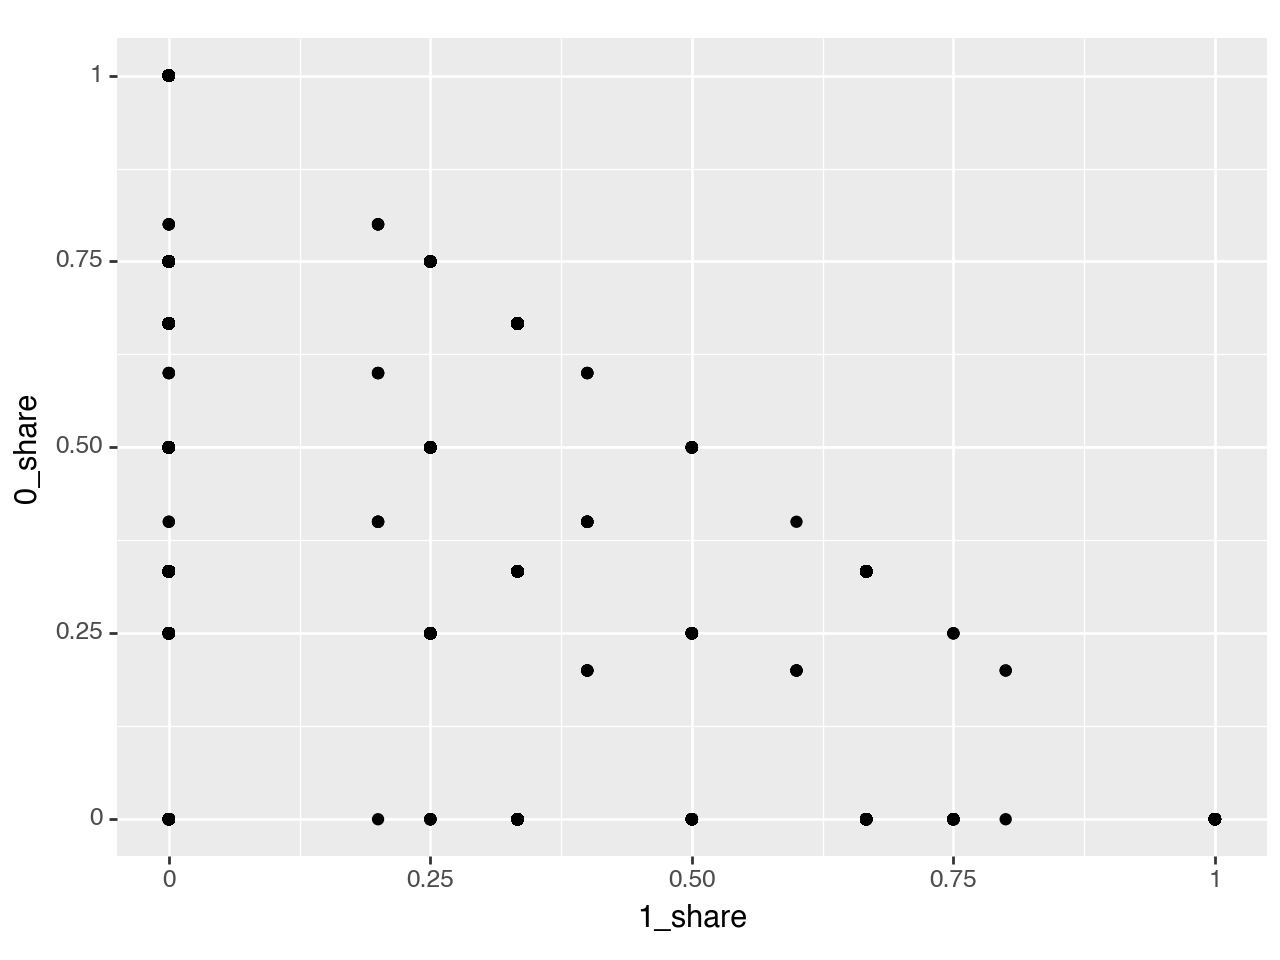

<Figure Size: (640 x 480)>

In [99]:
ggplot(gdf, aes(x = "1_share", y = "0_share")) + geom_point()

/Users/canyonfoot/Documents/python_proj/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


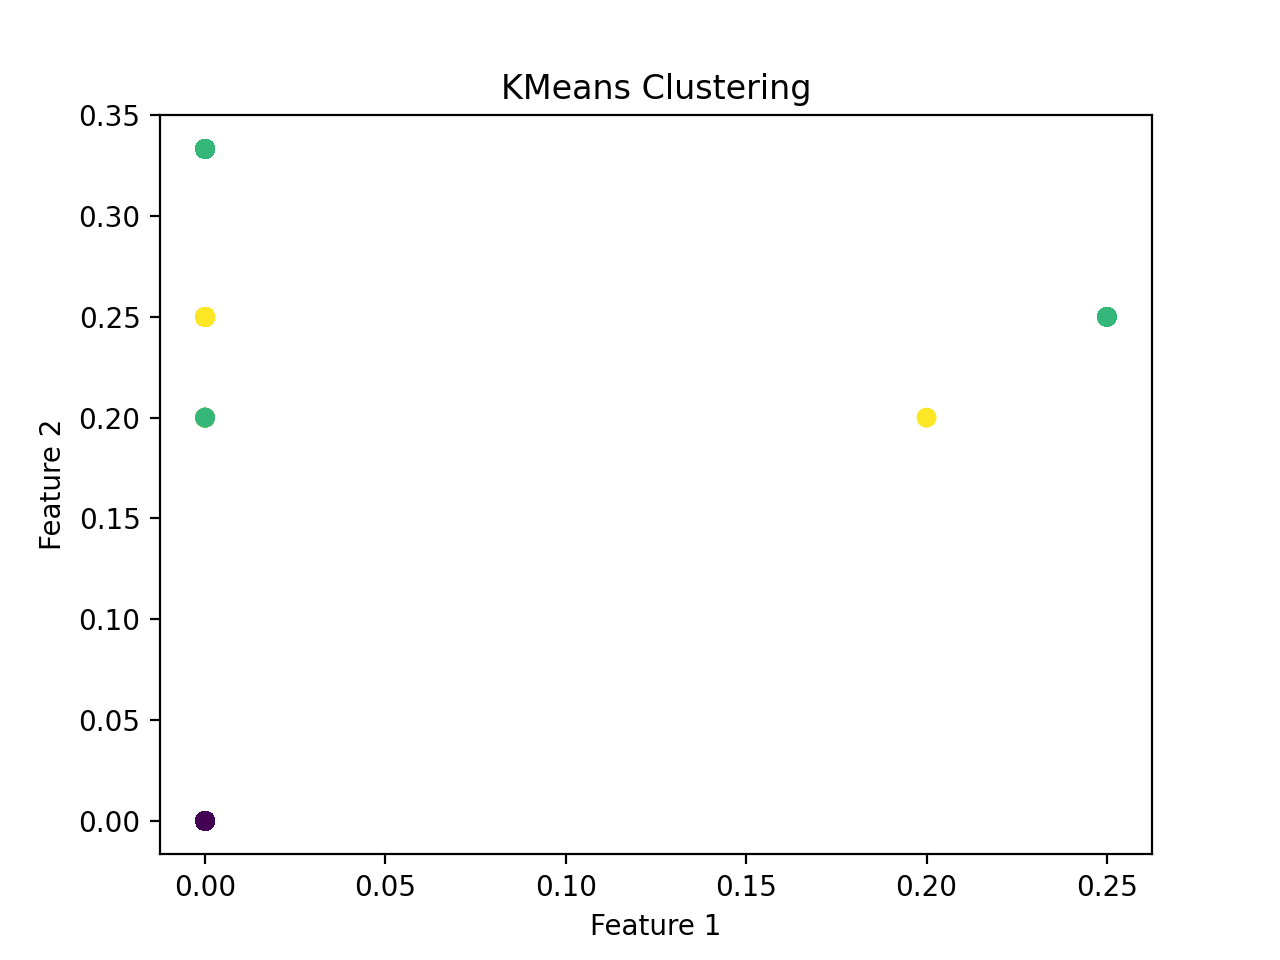

In [108]:
# Fit model to data

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)

X = gdf[["0_share", "1_share", "2_share", "3_share"]].to_numpy()
X = np.sort(X)

kmeans.fit(X)

# Predict the cluster for each data point
labels = kmeans.predict(X)

# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [109]:
# If you want to print the mean values with a more readable format
for i, centroid in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i} mean coordinates: {centroid}")

Cluster 0 mean coordinates: [-3.68628739e-18 -5.68989300e-16  3.31480284e-01  6.68519716e-01]
Cluster 1 mean coordinates: [-2.05998413e-18 -6.93889390e-17  7.21644966e-16  1.00000000e+00]
Cluster 2 mean coordinates: [0.00378451 0.33017216 0.33302167 0.33302167]
Cluster 3 mean coordinates: [0.00201342 0.24798658 0.24798658 0.50201342]


In [104]:
np.sort(X)

array([[0.        , 0.        , 0.33333333, 0.66666667],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.33333333, 0.66666667],
       ...,
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.25      , 0.75      ],
       [0.        , 0.        , 0.25      , 0.75      ]])

In [103]:
X

array([[0.66666667, 0.        , 0.        , 0.33333333],
       [1.        , 0.        , 0.        , 0.        ],
       [0.66666667, 0.        , 0.        , 0.33333333],
       ...,
       [1.        , 0.        , 0.        , 0.        ],
       [0.75      , 0.        , 0.        , 0.25      ],
       [0.75      , 0.        , 0.25      , 0.        ]])